# Advection

In [5]:
import autoroot
import jax
import jax.numpy as jnp
import numpy as np
import numba as nb
import equinox as eqx
import kernex as kex
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm, trange
from jaxtyping import Float, Array, PyTree, ArrayLike
import wandb
from jaxsw._src.domain.base import Domain
from jaxsw._src.models.pde import DynamicalSystem
from jaxsw._src.domain.time import TimeDomain

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
jax.config.update("jax_enable_x64", True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import urllib.request
import shutil


url = 'https://zenodo.org/record/4421428/files/'
file_name = 'mitgcm_example_dataset_v2.nc'
with urllib.request.urlopen(url + file_name) as response, open(file_name, 'wb') as out_file:
    shutil.copyfileobj(response, out_file)

# open the data
ds = xr.open_dataset(file_name)
ds

<xarray.Dataset>
Dimensions:  (time: 1, Z: 15, YC: 40, XG: 90, YG: 40, XC: 90, Zl: 15)
Coordinates: (12/25)
  * time     (time) timedelta64[ns] 11:00:00
    maskC    (Z, YC, XC) bool ...
    dyC      (YG, XC) float32 ...
    hFacC    (Z, YC, XC) float32 ...
    rA       (YC, XC) float32 ...
    hFacS    (Z, YG, XC) float32 ...
    ...       ...
    rAs      (YG, XC) float32 ...
    rAz      (YG, XG) float32 ...
    maskS    (Z, YG, XC) bool ...
    dxC      (YC, XG) float32 ...
    hFacW    (Z, YC, XG) float32 ...
  * XC       (XC) float32 2.0 6.0 10.0 14.0 18.0 ... 346.0 350.0 354.0 358.0
Data variables:
    UVEL     (time, Z, YC, XG) float32 ...
    VVEL     (time, Z, YG, XC) float32 ...
    WVEL     (time, Zl, YC, XC) float32 ...
    SALT     (time, Z, YC, XC) float32 ...
    THETA    (time, Z, YC, XC) float32 ...
    PH       (time, Z, YC, XC) float32 ...
    Eta      (time, YC, XC) float32 ...
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(extra_metadata=None, ll...

In [7]:
lon = ds.lon.values
lat = ds.lat.values
ssh = jnp.asarray(ds.ssh[0].values.T)


In [24]:
def plot_map(u):
    
    fig, ax = plt.subplots()
    
    pts = ax.pcolormesh(u.T, cmap="coolwarm")
    plt.colorbar(pts)
    
    plt.tight_layout()
    plt.show()

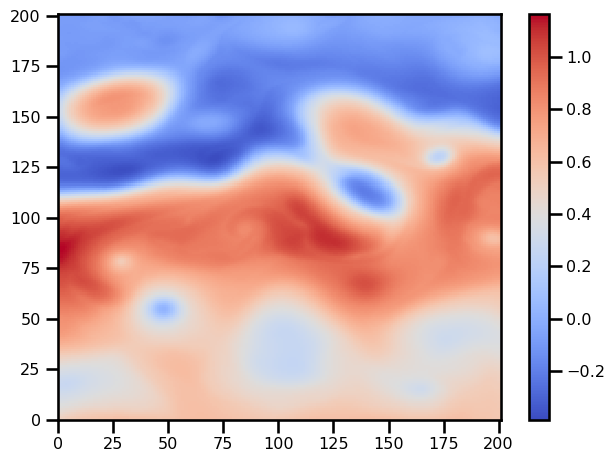

In [25]:
plot_map(ssh)

In [26]:
x_avg = 0.5*(ssh[:-1] + ssh[1:])

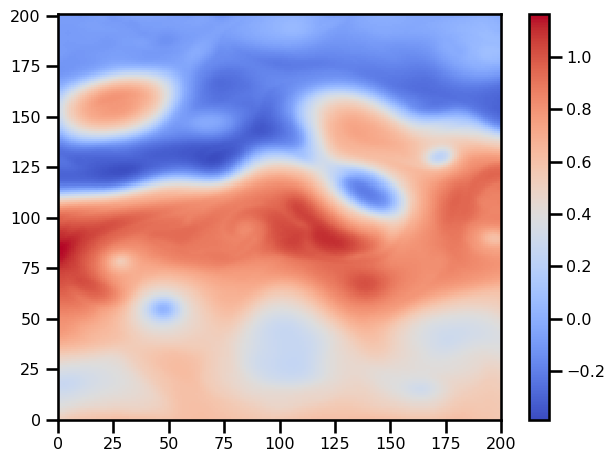

In [28]:
plot_map(x_avg)

In [63]:
Nx, Ny = 4, 4

u_ = jnp.zeros((Nx+3, Ny+2))
u = u_[1:-1,1:-1]

v_ = jnp.zeros((Nx+2, Ny+3))
v = v_[1:-1,1:-1]

phi_ = jnp.zeros((Nx+2,Ny+2))
phi = phi_[1:-1,1:-1]


In [78]:
Lx, Ly = 100, 100

dx = float(Lx) / Nx
dy = float(Ly) / Ny

# positions of nodes
ux = (-Lx/2 + jnp.arange(Nx + 1) * dx)
vx = (-Lx/2 + dx/2.0 + jnp.arange(Nx) * dx)

vy = (Ly/2 + jnp.arange(Ny + 1) * dy)[:, None]
uy = (Ly/2 + dy/2.0 + jnp.arange(Ny) * dy)



In [130]:
from jaxsw._src.operators.functional import grid

In [129]:
u_avg = x_average_2D(u)
u_avg

Array([[0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [1.5, 1.5, 1.5, 1.5, 1.5, 1.5],
       [2.5, 2.5, 2.5, 2.5, 2.5, 2.5],
       [3.5, 3.5, 3.5, 3.5, 3.5, 3.5],
       [4.5, 4.5, 4.5, 4.5, 4.5, 4.5],
       [5.5, 5.5, 5.5, 5.5, 5.5, 5.5]], dtype=float64)

In [120]:
u.shape, u_avg.shape

((6, 7), (5, 6))

In [150]:
from einops import repeat, rearrange

Nx, Ny = 4,4
u = jnp.arange(0,Nx+3)
v = jnp.arange(0,Ny+3)
phi = jnp.ones((Nx+2,Ny+2))
q = jnp.ones((Nx,Ny))

v = repeat(v, "Ny -> Nx Ny", Nx=Nx+2)
u = repeat(u, "Nx -> Nx Ny", Ny=Ny+2) 

u_interior = u[1:-1,1:-1]
v_interior = v[1:-1,1:-1]
phi_interior = phi[1:-1,1:-1]


phi.shape, q.shape, u.shape, v.shape

((6, 6), (4, 4), (7, 6), (6, 7))

In [151]:
u.shape, u_interior.shape

((7, 6), (5, 4))

## Fundamental Operations

### X-Average

This is a cell center operation. We basically need to sum the two sides (East-West) of the u-velocity

```python
u -- ⋅ -- u      u -- ⋅ -- u
|         |      | \     / |
⋅    Ψ    ⋅ -->  ⋅   Ψ,u̅   ⋅ 
|         |      |         |
u -- ⋅ -- u      u -- ⋅ -- u
```

$$
u\frac{\partial h}{\partial x}
$$


In [179]:
ubar = grid.x_average_2D(u)

assert ubar.shape == (Nx+2, Ny+2)
assert ubar.shape == phi.shape

### Y-Average

This is a cell center operation. We basically need to sum the two sides (North-South) of the v-velocity

$$
v \frac{\partial h}{\partial x}
$$

In [213]:
@kex.kmap(kernel_size=(1,2), padding=((0,0),(0,0)))
def y_average_2D(u: Array) -> Array:
    """Returns the two-point average at the centres between grid points.
    
    Grid:
        u -- ⋅ -- u
        |         | 
        u̅         u̅
        |         |
        u -- ⋅ -- u
    
    Args:
        u (Array): the field [Nx,Ny]
    
    Returns:
        ubar (Array): the field averaged [Nx, Ny-1]
    
    """
    return jnp.mean(u)

In [215]:

# vbar = grid.y_average_2D(v)
vbar = y_average_2D(v)

assert vbar.shape == phi.shape
# assert vbar.shape == (Nx+2, Ny+2)
v.shape, vbar.shape

((6, 7), (6, 6))

### Cell Averge

$$
u\frac{\partial v}{\partial x}
$$


```python
u -- ⋅ -- u      u -- ⋅ -- u
|         |      | \     / |
⋅    v    ⋅ -->  ⋅   v,u   ⋅ 
|         |      |         |
u -- ⋅ -- u      u -- ⋅ -- u
```

In [197]:
ubar = grid.center_average_2D(u)[1:-1,:]
assert ubar.shape == (Nx, Ny+1)
assert ubar.shape == v_interior.shape

$$
v\frac{\partial u}{\partial x}
$$


```python
v -- ⋅ -- v      v -- ⋅ -- v
|         |      | \     / |
⋅    u    ⋅ -->  ⋅   u,v   ⋅ 
|         |      |         |
v -- ⋅ -- v      v -- ⋅ -- v
```

In [198]:
vbar = grid.center_average_2D(v)[:,1:-1]
assert vbar.shape == (Nx+1, Ny)
assert vbar.shape == u_interior.shape

### Advection

This calculates the conservation of an advected tracer by the fluid flow.

$$
\frac{\partial q}{\partial t} + \nabla\cdot(uq) = 0
$$

$$
\nabla\cdot(uq) = \frac{\partial}{\partial x}\left(q u\right) + \frac{\partial}{\partial y}\left(q v \right)
$$

In [205]:
q_at_u = grid.x_average_2D(phi)[:, 1:-1]
q_at_v = grid.y_average_2D(phi)[1:-1,:]


assert q_at_u.shape == (Nx+1, Ny)
assert q_at_u.shape == u_interior.shape
assert q_at_v.shape == (Nx, Ny+1)
assert q_at_v.shape == v_interior.shape

In [208]:
grid.x_average_2D(phi).shape, grid.y_average_2D(phi).shape

((5, 6), (6, 5))